## 单因子的有效性分析就是从多因子里面选出有用的因子

## 多因子的相关性分析就是为了把相关性（斯皮尔曼系数）高的值进行合并

In [32]:
import scipy.stats as st
import pandas as pd
import numpy as np
from alphalens import performance
from alphalens import plotting
from alphalens import tears
from alphalens import utils
from sklearn.decomposition import PCA

In [3]:
# 去极值，标准化处理
def mad(factor):
    """自实现3倍中位数绝对值偏差去极值"""
    # 1、找出因子的中位数 median
    median_factor = np.median(factor)
    
    # 2、得到每个因子值与中位数的绝对偏差值 |x – median|
    # 3、得到绝对偏差值的中位数， MAD = median(|x – median|)
    mad = np.median(abs(factor-median_factor))
    
    # 4、计算MAD_e = 1.4826*MAD，然后确定参数 n，做出调整
    # 定义3倍中位数的上下限制
    high = median_factor + (3 * 1.4826 * mad)
    low = median_factor - (3 * 1.4826 * mad)
    
    # 利用3倍中位数的值去极值
    factor = np.where(factor > high, high, factor)
    factor = np.where(factor < low, low, factor)
    return factor

  
def stand(factor):
    """自实现标准化，相当于StandScaler"""
    mean = factor.mean()
    std_dev = factor.std()
    return (factor-mean)/std_dev

## 案例1.  计算2017-01-03（当天）的因子IC值:

- 分析：
    1. 获取这一天因子数据
    2. 获取2017-01-03与2017-01-04的价格数据，计算2017-01-04的收益率（下期收益率）
    3. 计算相关系数

In [4]:
# 默认在A股分析basic_earnings_per_share

# 1. 获取2017-01-03的因子暴露值，获取的是横截面数据
fund = get_fundamentals(query(fundamentals.income_statement.basic_earnings_per_share),entry_date="2017-01-03")[:,0,:]


# 2. 计算2017-01-04的收益率：
# 2.1 获取1月3日、1月4日的收盘价：
price_0103 = get_price(list(fund.index),start_date="2017-01-03",end_date="2017-01-03",fields="close").T    # DataFrame
# type(list(fund.index))    # list
# type(fund.index)          # pandas.indexes.base.Index
price_0104 = get_price(list(fund.index),start_date="2017-01-04",end_date="2017-01-04",fields="close").T


# 2.2 计算1月4日的收益率：
# 公式：（1月4日的收盘价 - 1月3日的收盘价）/ 1月3日的收盘价
# 不是用DataFrame相减，而是用DF里面的值【.iloc[:,0]】相减，
# [:]表示所有行数据，[0]表示第一列数据
return_rate = (price_0104.iloc[:,0] - price_0103.iloc[:,0]) / price_0103.iloc[:,0] 


# 3. 计算斯皮尔曼相关系数
st.spearmanr(fund['basic_earnings_per_share'], return_rate)    
# 相关系数为-0.01179, 因子与收益的相关性强度为-0.01179，
# 由此可知，此因子在1月3日与收益率之间的关系并不强

SpearmanrResult(correlation=-0.011804993850484408, pvalue=0.51548809343427582)

# 使用AlphaLens进行因子的IC分析

0. 默认在A股分析basic_earnings_per_share
1. 准备做分析的数据：因子值（MultiIndex），价格（DataFrame）
2. 因子值需要做去极值，标准化，中性化处理
3. 确定区间：2017-01-01 到 2018-01-01
4. 使用alphalens.utils.get_clean_factor_and_forward_returns准备alphalens分析的通用数据



## 1. 准备一个 MultiIndex DF的 factor 参数。区间2017-01-01 到2018-01-01

In [23]:
# 准备一个空DF，存放所有数据
all_data = pd.DataFrame()

# 1. 获取一年的交易日的日期列表：
date_list = get_trading_dates(start_date="2017-01-01",end_date="2018-01-01")

# for i in range(len(data_list))    
#    date_list[i]    先取索引，再通过索引取值。不如直接取值

for date in date_list:
    
    # 获取当天的因子数据DataFrame
    factor = get_fundamentals(query(fundamentals.financial_indicator.return_on_equity),entry_date=date)[:,0,:]
    # 多因子相关性分析：income_statement.basic_earnings_per_share 与 financial_indicator.return_on_equity
    
    # 新建日期列，为了使用date分组，生成索引
    factor["date"] = date
    
    # 每次循环一遍，把所有factor拼接(concat)在一起
    all_data = pd.concat([all_data,factor])
    
# 设置成双重索引，变成一个MultiIndex DataFrame。MultiIndex不是一个特定结构，而是具有双重索引的DataFrame
multiIndex_df = all_data.set_index(["date",all_data.index])

# 去极值，标准化处理
# multiIndex_df["basic_earnings_per_share"] = mad(multiIndex_df["basic_earnings_per_share"])
# multiIndex_df["basic_earnings_per_share"] = stand(multiIndex_df["basic_earnings_per_share"])


# 多因子，return_on_equity
multiIndex_df["return_on_equity"] = mad(multiIndex_df["return_on_equity"])
multiIndex_df["return_on_equity"] = stand(multiIndex_df["return_on_equity"])


# 把MultiIndex DataFrame变成MultiIndex Series
# single_factor_multiIndex_series = multiIndex_df["basic_earnings_per_share"]


# 多因子，return_on_equity
single_factor_multiIndex_series = multiIndex_df["return_on_equity"]

# pd.Series：带有股票索引的一维数组，相当于list + 股票索引
# pd.DataFrame：是将数个Series按列合并而成的二维数据结构，每一列单独取出来是一个Series
# np.ndarray：由两部分组成 = 实际的数据 + 描述这些数据的元数据

In [24]:
single_factor_multiIndex_series

date                   
2017-01-03  001979.XSHE       1.54278
            002826.XSHE       1.91459
            002827.XSHE       2.16881
            601155.XSHG      0.616547
            300498.XSHE       2.16881
            300585.XSHE       2.16881
            603058.XSHG       1.66218
            300577.XSHE       2.16881
            000166.XSHE      0.725109
            603996.XSHG     0.0794559
            603393.XSHG       1.22153
            600996.XSHG       2.16881
            300568.XSHE       2.16881
            300576.XSHE       1.68367
            300581.XSHE        1.1001
            300571.XSHE       2.16881
            601020.XSHG      0.833464
            601375.XSHG      0.550685
            603823.XSHG       2.16881
            603218.XSHG       2.16881
            603928.XSHG       2.16881
            300567.XSHE       2.16881
            300566.XSHE       2.16881
            002837.XSHE       2.16881
            300575.XSHE       1.48262
            300408.XSHE   

## 2. 准备所有A股的收盘价数据，区间2017-01-01到2018-01-01

In [8]:
# 2.1 获取所有A股代码
stocks = all_instruments("CS")["order_book_id"]

# 为了统一类型，使用list()强转，若不指定fields，则是panel结构
price = get_price(list(stocks),start_date="2017-01-01",end_date="2018-01-01", fields="close")
# alphalens可以自处理空缺值

In [9]:
price

,002723.XSHE,000910.XSHE,000700.XSHE,603929.XSHG,600349.XSHG,600827.XSHG,002088.XSHE,603488.XSHG,300182.XSHE,600525.XSHG,...,603500.XSHG,000587.XSHE,600095.XSHG,600993.XSHG,601798.XSHG,002087.XSHE,601567.XSHG,002195.XSHE,002580.XSHE,603817.XSHG
2017-01-03,25.47,18.9467,7.9718,7.6840,NaN,13.8634,12.3624,NaN,10.1488,13.6367,...,NaN,7.6251,12.8937,19.7671,13.72,7.2811,10.8560,5.0781,11.4958,NaN
2017-01-04,25.77,18.8775,8.0956,8.4504,NaN,13.9701,12.6068,NaN,10.2082,13.7253,...,NaN,7.6746,13.0330,19.8451,13.74,7.3501,11.2313,5.1498,11.6515,NaN
2017-01-05,25.56,19.0357,8.0385,9.2955,NaN,14.2514,12.3367,NaN,10.1092,13.7155,...,NaN,7.7934,13.0926,19.7085,14.00,7.2219,11.4096,5.2214,11.7076,NaN
2017-01-06,24.90,19.3126,8.0004,10.2289,NaN,14.5328,12.2209,NaN,10.3468,13.7844,...,NaN,7.7142,12.8539,20.0305,14.11,7.1923,11.1750,5.1139,11.5269,NaN
2017-01-09,25.19,18.9467,8.0004,11.2509,NaN,14.6395,12.2852,NaN,10.2775,13.8139,...,NaN,7.6845,12.8439,20.1086,14.09,7.2120,11.2032,5.1184,11.5768,NaN
2017-01-10,25.20,19.0851,8.0290,12.3809,NaN,14.6783,12.4460,NaN,10.1983,13.7942,...,NaN,7.6796,12.9335,19.8159,13.83,7.1232,11.1938,5.0781,11.4771,NaN
2017-01-11,24.70,18.2940,8.0766,13.6189,NaN,14.6298,12.0344,NaN,10.0696,13.8533,...,NaN,7.5310,12.8240,19.9817,13.58,7.0838,11.2032,5.0557,11.4646,NaN
2017-01-12,24.42,18.0963,7.8861,14.9848,NaN,14.3872,11.6935,NaN,9.9804,13.8533,...,NaN,7.5162,12.8141,19.6598,13.59,7.0640,11.1844,4.8542,11.2528,NaN
2017-01-13,23.96,18.0271,7.7432,16.4882,NaN,14.1253,11.3847,NaN,9.8220,14.1487,...,NaN,7.3379,12.8340,19.4744,13.12,7.2712,11.1563,4.5676,11.0783,NaN
2017-01-16,23.00,17.2360,7.4766,18.1389,NaN,14.1447,11.0824,NaN,9.3765,14.4145,...,NaN,7.0705,12.6251,18.8012,12.37,6.5609,10.9780,4.3392,10.2247,NaN


## 3. 生成通用的alphalens结构（并没有计算IC，只是生成结构）

In [25]:
factor_return = utils.get_clean_factor_and_forward_returns(single_factor_multiIndex_series,price)

In [26]:
factor_return
# asset：股票名
# periods:1（当期收益率=（当期收益率-上期收益率）/上期收益率）,5（5天收益率）,10（10天收益率）
# factor：因子暴露值
# factor_quantile：比如按照0.2，0.4，0.6，0.8分组，1，2，3，4，5就是每组区间

1         5        10      factor  \
date       asset                                                   
2017-01-03 002723.XSHE  0.011779 -0.010601 -0.064782   -0.682549   
           000910.XSHE -0.003652  0.007305 -0.076720     1.54287   
           000700.XSHE  0.015530  0.007175 -0.065707    0.369196   
           603929.XSHG  0.099740  0.611257  1.597189     2.16881   
           600827.XSHG  0.007697  0.058781  0.051784    0.118488   
           002088.XSHE  0.019770  0.006762 -0.087928  -0.0403559   
           300182.XSHE  0.005853  0.004877 -0.072196     1.01309   
           600525.XSHG  0.006497  0.011550  0.062090    0.707333   
           603008.XSHG  0.000544 -0.033354 -0.092949    0.776531   
           300258.XSHE -0.004757 -0.020396 -0.048945     1.24884   
           300239.XSHE  0.013435  0.020756 -0.059828   -0.475681   
           300080.XSHE  0.016211 -0.016211 -0.085106   -0.834163   
           600764.XSHG  0.015491  0.020773 -0.019718    -0.93827   
           002455.XSHE -0.011581 -0.011581 -0.074129    0.706318   
           002094.XSHE -0.003752 -0.093752 -0.068750     1.09905   
           000906.XSHE  0.039089  0.072962 -0.057335    0.365094   
           600873.XSHG  0.024231  0.016659  0.021202    0.761324   
           300160.XSHE -0.000831 -0.007485 -0.075703    0.689205   
           000860.XSHE  0.003684 -0.008289 -0.051568 -0.00341581   
           600391.XSHG  0.002473  0.030511 -0.000826   -0.376297   
           600227.XSHG  0.016598 -0.016598 -0.069156    -1.60593   
           600756.XSHG  0.012041 -0.000861 -0.118711    -0.27625   
           600069.XSHG -0.018180 -0.109082 -0.197719    -1.79581   
           603889.XSHG  0.004556 -0.018881 -0.075517     1.78353   
           300029.XSHE -0.003891 -0.043450 -0.160182    -2.53891   
           300165.XSHE  0.015771  0.006902 -0.086696    -0.13224   
           601177.XSHG -0.002751  0.017449 -0.062439   -0.773335   
           002788.XSHE  0.013356 -0.036393 -0.168614    0.717734   
           000413.XSHE  0.014035 -0.003504 -0.114909   0.0642075   
           600184.XSHG -0.003680  0.148641  0.103083   -0.785662   
...                          ...       ...       ...         ...   
2017-12-15 603328.XSHG  0.007086  0.001420  0.017011     1.01688   
           603605.XSHG  0.005173 -0.006280  0.061347     2.16881   
           002862.XSHE -0.016491 -0.034385 -0.003511    0.821323   
           600701.XSHG -0.026168 -0.039252 -0.056075    0.195352   
           603567.XSHG -0.002139  0.012850  0.008564    0.812808   
           300595.XSHE -0.016811  0.003715 -0.009970     2.16881   
           000586.XSHE  0.010971  0.019199 -0.016456   -0.775593   
           300491.XSHE -0.035087 -0.102757 -0.106765    -1.07934   
           002028.XSHE -0.012643 -0.030703 -0.045755   0.0408377   
           002472.XSHE -0.019821 -0.017836 -0.029727    0.382165   
           600058.XSHG  0.015491  0.009466  0.039587   -0.698606   
           002198.XSHE -0.000806 -0.009670 -0.009670   -0.566384   
           002465.XSHE -0.005615  0.000000  0.077534   -0.355848   
           002690.XSHE -0.018451 -0.023579 -0.012299     1.76944   
           000863.XSHE -0.014563 -0.058196 -0.038183   -0.657853   
           000897.XSHE -0.002849 -0.017094 -0.037037    -1.64345   
           300168.XSHE  0.000763 -0.001519  0.027440    0.138688   
           600863.XSHG  0.003456  0.027582  0.024125   0.0425987   
           300487.XSHE  0.028501 -0.005939  0.010689     1.24099   
           002274.XSHE  0.012505  0.002773  0.004173   -0.713274   
           603500.XSHG  0.013891  0.005719  0.055964     1.23233   
           000587.XSHE  0.001481  0.020741  0.037037    0.857124   
           600095.XSHG -0.016058 -0.003221 -0.004816   -0.680353   
           600993.XSHG  0.006407  0.031063  0.009861     1.55337   
           601798.XSHG -0.001091  0.020720  0.031625   -0.811332   
           002087.XSHE  0.024917  0.000000 -0.033223     0.74995   
           601567.X

## 4. 进行IC分析，计算每天的相关系数

In [27]:
# 默认每天的IC值，为了筛选因子
IC = performance.factor_information_coefficient(factor_return)

In [28]:
# 默认只看1期的IC值
# IC_basic_earnings_per_share = IC

# 多因子相关性分析return_on_equity
IC_return_on_equity = IC

# IC_basic_earnings_per_share
IC_return_on_equity

,1,5,10
date,,,
2017-01-03,-0.004926,-0.158036,0.033497
2017-01-04,-0.141452,-0.137654,0.027752
2017-01-05,-0.114012,-0.085087,0.060235
2017-01-06,-0.031832,0.011761,0.108816
2017-01-09,-0.010458,0.111933,0.110836
2017-01-10,-0.026582,0.153717,0.095054
2017-01-11,0.059090,0.127093,0.149764
2017-01-12,0.064805,0.144074,0.155138
2017-01-13,0.180446,0.176374,0.140774


## 5. IC结果分析（区间2017-01-01 到2018-01-01）

因子有效性分析表格填充：
- IC_mean = 0.031
- IC_std = 0.094
- IC > 0.02 = 0.55
- IR = IC_mean / IC_std = 0.329
- IC_mean一定，IC Std方差越小，IR越大，越稳定


- 多个因子并进行打分，选取最优因子

/opt/conda/envs/ricequant/lib/python3.5/site-packages/alphalens/plotting.py:215: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).mean()
  pd.rolling_mean(ic, 22).plot(ax=a,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3347a039b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f33472bd320>], dtype=object)

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


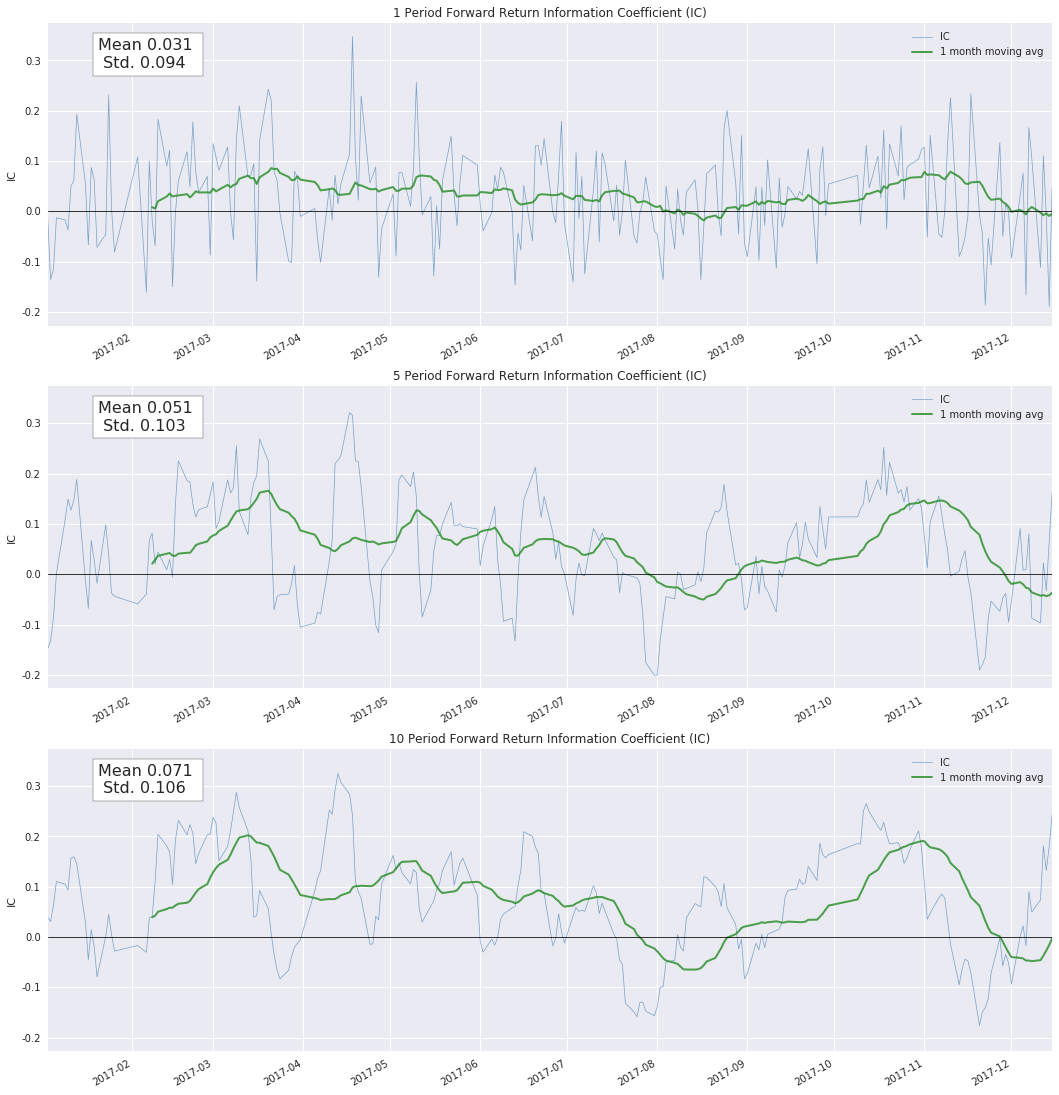

In [15]:
# 时间序列和移动平均图
plotting.plot_ic_ts(IC)
# 收益都大于0，所以收益与IC呈正相关


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3346e7bcc0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3346e2b6d8>], dtype=object)

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


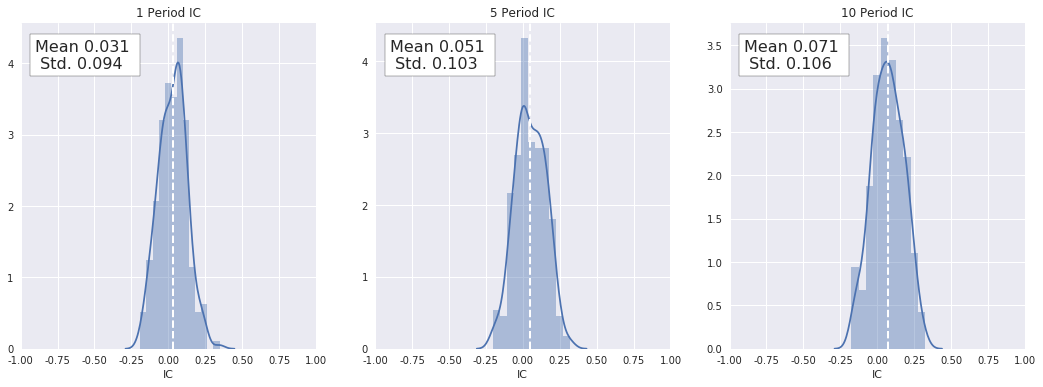

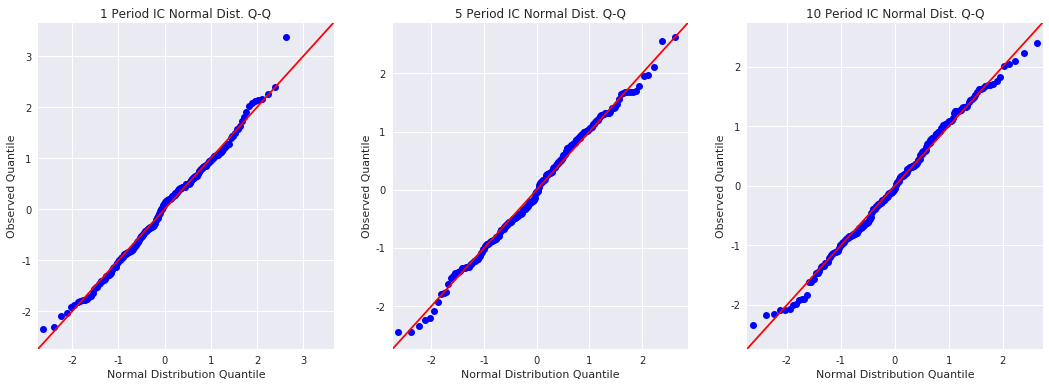

In [16]:
# 因子的IC分布图
plotting.plot_ic_hist(IC)    # 符合正态分布
# QQ图：横纵坐标为因子的分位数的值，如果画出来为一条直线，则符合正态分布。
plotting.plot_ic_qq(IC)

# 其他：月度热力图
# 颜色越深，越接近1，代表正相关
# 颜色越浅，越接近-1，代表负相关

In [17]:
# 得出IC > 0.02的比例
a = IC.iloc[:, 0]

len(a[a > 0.02])/len(a)

0.5512820512820513

In [18]:
# 因子IR（信息比率）代表因子在历史上表现的稳定性
# 假设IC均值一定， IC的波动率越小，因子表现越稳定，IR就越大 。

# IR = IC均值/IC的波动率(std_dex)
IR = 0.031/0.094
IR

0.32978723404255317

## 6. 利用alphalens进行因子收益率分析：

**建立回归方程，得出分组结果和因子的平均收益**

Returns Analysis


,1,5,10
Ann. alpha,0.306,0.281,0.251
beta,-0.025,-0.052,-0.015
Mean Period Wise Return Top Quantile (bps),14.539,67.391,118.666
Mean Period Wise Return Bottom Quantile (bps),-9.044,-42.108,-77.751
Mean Period Wise Spread (bps),23.840,22.127,19.808


/opt/conda/envs/ricequant/lib/python3.5/site-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False,min_periods=1).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/opt/conda/envs/ricequant/lib/python3.5/site-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False,min_periods=1).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/opt/conda/envs/ricequant/lib/python3.5/site-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False,min_periods=1).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/opt/c

<Figure size 576x396 with 0 Axes>

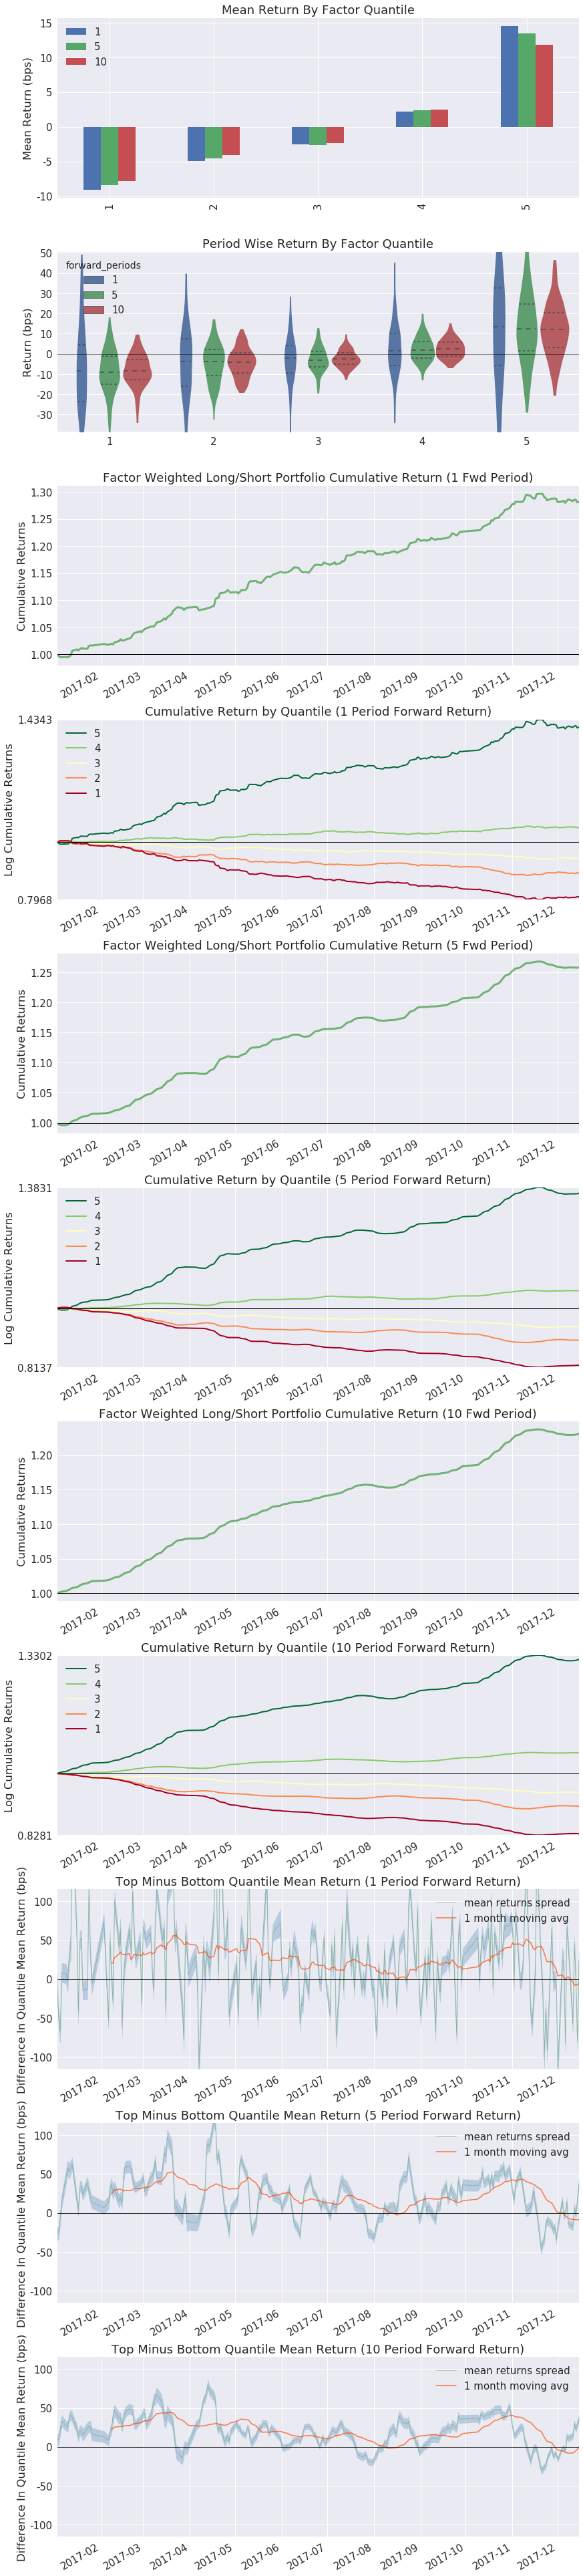

In [19]:
# factor_return包含因子值（特征值）和股票收益率（目标值）
tears.create_returns_tear_sheet(factor_return)
# 选择因子值大于80%以上的，收益率最高

# 图1. 因子收益率方向：
# 5组表示5个分位数分出来的组
# 纵坐标：【因子的平均收益】
# 横坐标：因子暴露度
# 在第五组，收益最高：
# 大于80%分位数的股票，都是收益较高的
# 通过因子方向选股
# 此案例中，选择市值最大的10支股票

# 图4. 累计的因子收益率分组
# 只有第5组（80%以上）的因子值，表现最好

In [20]:
# 因子在周期内的平均收益率
performance.factor_returns(factor_return).iloc[:,0].mean()

0.0010642514842060845

## 7. 多因子的相关性分析

In [29]:
IC_basic_earnings_per_share

,1,5,10
date,,,
2017-01-03,-0.011701,-0.147827,0.039321
2017-01-04,-0.135324,-0.132014,0.030686
2017-01-05,-0.115467,-0.085873,0.064601
2017-01-06,-0.012942,0.001696,0.110347
2017-01-09,-0.017003,0.108101,0.105188
2017-01-10,-0.037181,0.149594,0.093616
2017-01-11,0.049791,0.127275,0.156603
2017-01-12,0.060764,0.147691,0.159654
2017-01-13,0.193312,0.188636,0.146400


In [30]:
# 对IC_basic_earnings_per_share和IC_return_on_equity做相关性分析，
st.spearmanr(IC_basic_earnings_per_share.iloc[:,0], IC_return_on_equity.iloc[:,0])

SpearmanrResult(correlation=0.98655924175054865, pvalue=1.5903317107192632e-184)

## 8. 进行因子合成 - 对因子的暴露值进行合成

In [31]:
# 准备DF存放数据
earn_return = pd.DataFrame()

for date in date_list:
    fund = get_fundamentals(query(fundamentals.financial_indicator.return_on_equity,
                              fundamentals.income_statement.basic_earnings_per_share),entry_date=date)[:,0,:]
    earn_return = pd.concat([earn_return,fund])

In [33]:
earn_return

,return_on_equity,basic_earnings_per_share
001979.XSHE,11.5807,0.71
002826.XSHE,13.3753,0.25
002827.XSHE,23.1698,0.58
601155.XSHG,7.11,0.44
300498.XSHE,41.9725,2.0759
300585.XSHE,17.4568,0.31
603058.XSHG,12.157,0.1773
300577.XSHE,30.3098,1.28
000166.XSHE,7.634,0.19
603996.XSHG,4.5176,0.2029


In [35]:
# PCA不允许有空值，所以用平均值填充空值
earn_return["return_on_equity"] = earn_return["return_on_equity"].fillna(earn_return["return_on_equity"].mean())
earn_return["basic_earnings_per_share"] = earn_return["basic_earnings_per_share"].fillna(earn_return["basic_earnings_per_share"].mean())

In [36]:
# 将两个因子合成一个结果，n_components=1
pca = PCA(n_components=1)

# pca.fit_transform(earn_return), 需要向转换器传入一个DataFrame

# type(earn_return[["return_on_equity"]])    # pandas.core.frame.DataFrame
# type(earn_return["return_on_equity"])    # pandas.core.series.Series

# 合成一个新的因子，与其他因子一起选股
pca.fit_transform(earn_return[["return_on_equity","basic_earnings_per_share"]])

array([[ -7.68537934],
       [ -9.47617322],
       [-19.27303612],
       ..., 
       [  1.55548761],
       [ -3.14362678],
       [ -4.04146765]])